In [205]:
from collections import defaultdict, Counter
import numpy as np
import math
import matplotlib.pyplot as plt
import matplotlib
from itertools import combinations, product
import scipy.stats as stats

In [206]:
# need affected/unaffected information
# these files can be found on sherlock
# '../data/v34.vcf.ped' = /scratch/PI/dpwall/DATA/iHART/vcf/v3.4/v34.vcf.ped
# '../data/ssc.ped' = /scratch/PI/dpwall/DATA/iHART/vcf/SSC/ssc.ped

ped_files = ['../data/v34.vcf.ped', '../data/ssc.ped']
# Affection (0=unknown; 1=unaffected; 2=affected)
child_id_to_affected = dict()
child_id_to_sex = dict()

for ped_file in ped_files:
    with open(ped_file, 'r') as f:
        for line in f:
            pieces = line.strip().split('\t')
            if len(pieces) >= 6:
                fam_id, child_id, f_id, m_id, sex, disease_status = pieces[0:6]
                child_id_to_affected[child_id] = disease_status
                child_id_to_sex[child_id] = sex

In [207]:
# for this analysis, we remove families with monozygotic multiples

monozygotic_multiple_families = set()
with open('../data/160826.iHART.db.query.csv', 'r') as f:
    next(f)
    for line in f:
        pieces = line.split(',')
        if 'MZ' in pieces[11]:
            monozygotic_multiple_families.add(pieces[3])
print('Mono multiples', len(monozygotic_multiple_families))

Mono multiples 96


In [208]:
#chroms = [str(x) for x in range(21, 23)] #+ 
chroms = ['X']

ihart_family_sizes = [3, 4, 5, 6, 7]
ihart_phase_dir = '../phased_ihart'

ihart_quad_family_sizes = [4]
ihart_quad_phase_dir = '../phased_ihart_quad'

ssc_family_sizes = [4]
ssc_phase_dir = '../phased_ssc'


In [209]:
# filter families by various criteria

def pull_ok_families(phase_dir, family_sizes):

    # make sure we have data from every chromosome for each family
    family_to_chroms = defaultdict(set)
    family_to_individuals = dict()
    for chrom in chroms:
        print(chrom, end=' ')

        for j in family_sizes:
            try:
                with open('%s/chr.%s.familysize.%d.families.txt' % (phase_dir, chrom, j), 'r') as f:
                    next(f) # skip header
                    for line in f:
                        pieces = line.strip().split('\t')
                        family_key = pieces[0]
                        family_to_chroms[family_key].add(chrom)
                        family_to_individuals[family_key] = pieces[1:(1+j)]
            except FileNotFoundError:
                print('File not found', 'chrom', chrom, 'family size', j)
            except StopIteration:
                print('File empty', 'chrom', chrom, 'family size', j)

    families_with_all_chroms = set([k for k, v in family_to_chroms.items() if len(v)==len(chroms)])
    print('Families with all chroms', len(families_with_all_chroms))
    print(Counter([len(v) for v in family_to_chroms.values()]))
    
    # some individuals in iHART have data on WB and LCL, we these families as well, since the phasing algorithm 
    # naively treated these samples as coming from different people - I need to go back and fix this
    families_with_lcl = set([x for x, inds in family_to_individuals.items() if len([y for y in inds if 'LCL' in y]) > 0])
    print('Families with LCL', len(families_with_lcl))
    
    families_to_include = dict([(x, family_to_individuals[x]) for x in families_with_all_chroms if x not in families_with_lcl and x.split('.')[0]  not in monozygotic_multiple_families])
    print('Final families', len(families_to_include))
    
    return families_to_include

ok_ihart_families = pull_ok_families(ihart_phase_dir, ihart_family_sizes)
ok_ihart_quad_families = pull_ok_families(ihart_quad_phase_dir, ihart_quad_family_sizes)
ok_ssc_families = pull_ok_families(ssc_phase_dir, ssc_family_sizes)



X Families with all chroms 880
Counter({1: 880})
Families with LCL 0
Final families 795
X Families with all chroms 2048
Counter({1: 2048})
Families with LCL 0
Final families 1828
X Families with all chroms 518
Counter({1: 518})
Families with LCL 0
Final families 518


In [210]:
def load_phase_data(phase_dir, family_sizes, families_to_include):
    sibpair_to_mat_match = defaultdict(int)
    sibpair_to_mat_mismatch = defaultdict(int)
    sibpair_to_pat_match = defaultdict(int)
    sibpair_to_pat_mismatch = defaultdict(int)

    for chrom in chroms:
        print(chrom, end=' ')

        # pull families
        family_to_individuals = dict()
        for j in family_sizes:
            with open('%s/chr.%s.familysize.%d.families.txt' % (phase_dir, chrom, j), 'r')  as f: 
                next(f) # skip header
                for line in f:
                    pieces = line.strip().split('\t')
                    family_key = pieces[0]
                    if family_key in families_to_include.keys():
                        family_to_individuals[family_key] = pieces[1:(1+j)]


        # now read phase info
        for j in family_sizes:
            # load deletions
            with open('%s/chr.%s.familysize.%d.phased.txt' % (phase_dir, chrom, j), 'r')  as f:
                next(f) # skip header

                for line in f:
                    pieces = line.strip().split('\t')
                    family_key = pieces[0]
                    if family_key in families_to_include.keys():
                        inheritance_state = [int(x) for x in pieces[1:(2+(j*2))]]
                        start_pos, end_pos = [int(x) for x in pieces[(2+(j*2)):(4+(j*2))]]
                        length = end_pos - start_pos + 1

                        has_m1, has_m2, has_p1, has_p2 = [], [], [], []
                        children = family_to_individuals[family_key][2:]
                        if inheritance_state[-1] == 0:
                            for i, child in enumerate(children):
                                if inheritance_state[4+(2*i)] == 0:
                                    has_m1.append(child)
                                elif inheritance_state[4+(2*i)] == 1:
                                    has_m2.append(child)
                                if inheritance_state[5+(2*i)] == 0:
                                    has_p1.append(child)
                                elif inheritance_state[5+(2*i)] == 1:
                                    has_p2.append(child)
                                    
                        # matches
                        for c1, c2 in combinations(has_m1, 2):
                            sibpair_to_mat_match[(min(c1, c2), max(c1, c2))] += length
                        for c1, c2 in combinations(has_m2, 2):
                            sibpair_to_mat_match[(min(c1, c2), max(c1, c2))] += length
                        for c1, c2 in combinations(has_p1, 2):
                            sibpair_to_pat_match[(min(c1, c2), max(c1, c2))] += length
                        for c1, c2 in combinations(has_p2, 2):
                            sibpair_to_pat_match[(min(c1, c2), max(c1, c2))] += length
                            
                        # mismatches
                        for c1, c2 in product(has_m1, has_m2):
                            sibpair_to_mat_mismatch[(min(c1, c2), max(c1, c2))] += length
                        for c1, c2 in product(has_p1, has_p2):
                            sibpair_to_pat_mismatch[(min(c1, c2), max(c1, c2))] += length
    return sibpair_to_mat_match, sibpair_to_mat_mismatch, sibpair_to_pat_match, sibpair_to_pat_mismatch

print('iHART')
ihart_sibpair_to_mat_match, ihart_sibpair_to_mat_mismatch, ihart_sibpair_to_pat_match, ihart_sibpair_to_pat_mismatch = load_phase_data(ihart_phase_dir, ihart_family_sizes, ok_ihart_families)
print('iHART quad')
ihart_quad_sibpair_to_mat_match, ihart_quad_sibpair_to_mat_mismatch, ihart_quad_sibpair_to_pat_match, ihart_quad_sibpair_to_pat_mismatch = load_phase_data(ihart_quad_phase_dir, ihart_quad_family_sizes, ok_ihart_quad_families)
print('SSC')
ssc_sibpair_to_mat_match, ssc_sibpair_to_mat_mismatch, ssc_sibpair_to_pat_match, ssc_sibpair_to_pat_mismatch  = load_phase_data(ssc_phase_dir, ssc_family_sizes, ok_ssc_families)



iHART
X iHART quad
X SSC
X 

Removing 69 outliers iHART
Removing 107 outliers iHART quad
Removing 2 outliers SSC


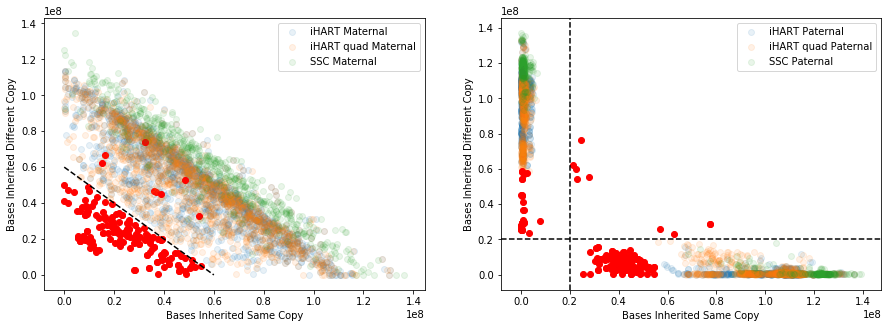

In [221]:
# needs to be hand-tuned
def find_outliers(mat_match, mat_mismatch, pat_match, pat_mismatch):
    if chroms == ['X']:
        pat_ok = (pat_match < 0.2*pow(10, 8)) | (pat_mismatch < 0.2*pow(10, 8))
        return ~pat_ok | (mat_match+mat_mismatch < 0.6*pow(10, 8)) 
    else:
        cutoff = 0.5*pow(10, 9)
        return (mat_mismatch < cutoff) | (pat_mismatch < cutoff)
    
def plot_outlier_cutoffs():
    cutoff = 0.6*pow(10, 8)
    
    plt.subplot(1, 2, 1)
    plt.plot([0, cutoff], [cutoff, 0], color='black', linestyle='--')
    
    plt.subplot(1, 2, 2)
    plt.axhline(0.2*pow(10, 8), color='black', linestyle='--')
    plt.axvline(0.2*pow(10, 8), color='black', linestyle='--')
    #plt.plot([0, 0.1*pow(10, 8)], [cutoff, cutoff], color='black', linestyle='--')
    #plt.plot([0.1*pow(10, 8), 0.1*pow(10, 8)], [cutoff, plt.ylim()[1]], color='black', linestyle='--')
    
    #plt.plot([cutoff, cutoff], [0, 0.1*pow(10, 8)], color='black', linestyle='--')
    #plt.plot([cutoff, plt.ylim()[1]], [0.1*pow(10, 8), 0.1*pow(10, 8)], color='black', linestyle='--')
    

plt.figure(figsize=(15, 5))

ihart_sibpairs = sorted(set(ihart_sibpair_to_mat_match.keys()) & set(ihart_quad_sibpair_to_mat_match.keys()))

ihart_mat_match = np.array([ihart_sibpair_to_mat_match[k] for k in ihart_sibpairs])
ihart_mat_mismatch = np.array([ihart_sibpair_to_mat_mismatch[k] for k in ihart_sibpairs])
ihart_pat_match = np.array([ihart_sibpair_to_pat_match[k] for k in ihart_sibpairs])
ihart_pat_mismatch = np.array([ihart_sibpair_to_pat_mismatch[k] for k in ihart_sibpairs])

ihart_outliers = find_outliers(ihart_mat_match, ihart_mat_mismatch, ihart_pat_match, ihart_pat_mismatch)
print('Removing %d outliers iHART' % np.sum(ihart_outliers))

plt.subplot(1, 2, 1)
plt.scatter(ihart_mat_match, ihart_mat_mismatch, alpha=0.1, label='iHART Maternal')
plt.scatter(ihart_mat_match[ihart_outliers], ihart_mat_mismatch[ihart_outliers], color='red')

plt.subplot(1, 2, 2)
plt.scatter(ihart_pat_match, ihart_pat_mismatch, alpha=0.1, label='iHART Paternal')
plt.scatter(ihart_pat_match[ihart_outliers], ihart_pat_mismatch[ihart_outliers], color='red')

ihart_quad_mat_match = np.array([ihart_quad_sibpair_to_mat_match[k] for k in ihart_sibpairs])
ihart_quad_mat_mismatch = np.array([ihart_quad_sibpair_to_mat_mismatch[k] for k in ihart_sibpairs])
ihart_quad_pat_match = np.array([ihart_quad_sibpair_to_pat_match[k] for k in ihart_sibpairs])
ihart_quad_pat_mismatch = np.array([ihart_quad_sibpair_to_pat_mismatch[k] for k in ihart_sibpairs])

ihart_quad_outliers = find_outliers(ihart_quad_mat_match, ihart_quad_mat_mismatch, ihart_quad_pat_match, ihart_quad_pat_mismatch)
print('Removing %d outliers iHART quad' % np.sum(ihart_quad_outliers))

plt.subplot(1, 2, 1)
plt.scatter(ihart_quad_mat_match, ihart_quad_mat_mismatch, alpha=0.1, label='iHART quad Maternal')
plt.scatter(ihart_quad_mat_match[ihart_quad_outliers], ihart_quad_mat_mismatch[ihart_quad_outliers], color='red')

plt.subplot(1, 2, 2)
plt.scatter(ihart_quad_pat_match, ihart_quad_pat_mismatch, alpha=0.1, label='iHART quad Paternal')
plt.scatter(ihart_quad_pat_match[ihart_quad_outliers], ihart_quad_pat_mismatch[ihart_quad_outliers], color='red')

ssc_sibpairs = sorted(ssc_sibpair_to_mat_match.keys())
ssc_mat_match = np.array([ssc_sibpair_to_mat_match[k] for k in ssc_sibpairs])
ssc_mat_mismatch = np.array([ssc_sibpair_to_mat_mismatch[k] for k in ssc_sibpairs])
ssc_pat_match = np.array([ssc_sibpair_to_pat_match[k] for k in ssc_sibpairs])
ssc_pat_mismatch = np.array([ssc_sibpair_to_pat_mismatch[k] for k in ssc_sibpairs])

ssc_outliers = find_outliers(ssc_mat_match, ssc_mat_mismatch, ssc_pat_match, ssc_pat_mismatch)
print('Removing %d outliers SSC' % np.sum(ssc_outliers))

plt.subplot(1, 2, 1)
plt.scatter(ssc_mat_match, ssc_mat_mismatch, alpha=0.1, label='SSC Maternal')
plt.scatter(ssc_mat_match[ssc_outliers], ssc_mat_mismatch[ssc_outliers], color='red')

plt.subplot(1, 2, 2)
plt.scatter(ssc_pat_match, ssc_pat_mismatch, alpha=0.1, label='SSC Paternal')
plt.scatter(ssc_pat_match[ssc_outliers], ssc_pat_mismatch[ssc_outliers], color='red')


ihart_sibpairs = [ihart_sibpairs[i] for i in np.where(~ihart_outliers & ~ihart_quad_outliers)[0]]
ihart_mat_match = ihart_mat_match[~ihart_outliers & ~ihart_quad_outliers]
ihart_mat_mismatch = ihart_mat_mismatch[~ihart_outliers & ~ihart_quad_outliers]
ihart_pat_match = ihart_pat_match[~ihart_outliers & ~ihart_quad_outliers]
ihart_pat_mismatch = ihart_pat_mismatch[~ihart_outliers & ~ihart_quad_outliers]

ihart_quad_mat_match = ihart_quad_mat_match[~ihart_outliers & ~ihart_quad_outliers]
ihart_quad_mat_mismatch = ihart_quad_mat_mismatch[~ihart_outliers & ~ihart_quad_outliers]
ihart_quad_pat_match = ihart_quad_pat_match[~ihart_outliers & ~ihart_quad_outliers]
ihart_quad_pat_mismatch = ihart_quad_pat_mismatch[~ihart_outliers & ~ihart_quad_outliers]

ssc_sibpairs = [ssc_sibpairs[i] for i in np.where(~ssc_outliers)[0]]
ssc_mat_match = ssc_mat_match[~ssc_outliers]
ssc_mat_mismatch = ssc_mat_mismatch[~ssc_outliers]
ssc_pat_match = ssc_pat_match[~ssc_outliers]
ssc_pat_mismatch = ssc_pat_mismatch[~ssc_outliers]


plt.subplot(1, 2, 1)
plt.legend()
plt.xlabel('Bases Inherited Same Copy')
plt.ylabel('Bases Inherited Different Copy')

plt.subplot(1, 2, 2)
plt.legend()
plt.xlabel('Bases Inherited Same Copy')
plt.ylabel('Bases Inherited Different Copy')

plot_outlier_cutoffs()
plt.show()

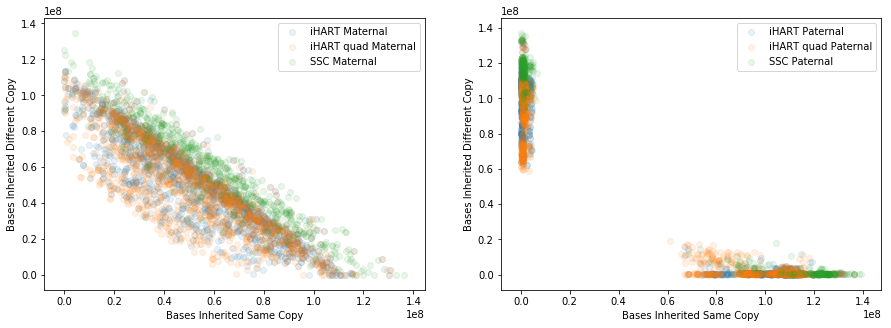

In [212]:
plt.figure(figsize=(15, 5))

plt.subplot(1, 2, 1)
plt.scatter(ihart_mat_match, ihart_mat_mismatch, alpha=0.1, label='iHART Maternal')
plt.subplot(1, 2, 2)
plt.scatter(ihart_pat_match, ihart_pat_mismatch, alpha=0.1, label='iHART Paternal')

plt.subplot(1, 2, 1)
plt.scatter(ihart_quad_mat_match, ihart_quad_mat_mismatch, alpha=0.1, label='iHART quad Maternal')
plt.subplot(1, 2, 2)
plt.scatter(ihart_quad_pat_match, ihart_quad_pat_mismatch, alpha=0.1, label='iHART quad Paternal')

plt.subplot(1, 2, 1)
plt.scatter(ssc_mat_match, ssc_mat_mismatch, alpha=0.1, label='SSC Maternal')
plt.subplot(1, 2, 2)
plt.scatter(ssc_pat_match, ssc_pat_mismatch, alpha=0.1, label='SSC Paternal')

plt.subplot(1, 2, 1)
plt.xlabel('Bases Inherited Same Copy')
plt.ylabel('Bases Inherited Different Copy')
plt.legend()

plt.subplot(1, 2, 2)
plt.xlabel('Bases Inherited Same Copy')
plt.ylabel('Bases Inherited Different Copy')
plt.legend()

plt.show()

In [213]:
ihart_mat = ihart_mat_match/(ihart_mat_match+ihart_mat_mismatch)
ihart_pat = ihart_pat_match/(ihart_pat_match+ihart_pat_mismatch)

ihart_quad_mat = ihart_quad_mat_match/(ihart_quad_mat_match+ihart_quad_mat_mismatch)
ihart_quad_pat = ihart_quad_pat_match/(ihart_quad_pat_match+ihart_quad_pat_mismatch)

ssc_mat = ssc_mat_match/(ssc_mat_match+ssc_mat_mismatch)
ssc_pat = ssc_pat_match/(ssc_pat_match+ssc_pat_mismatch)

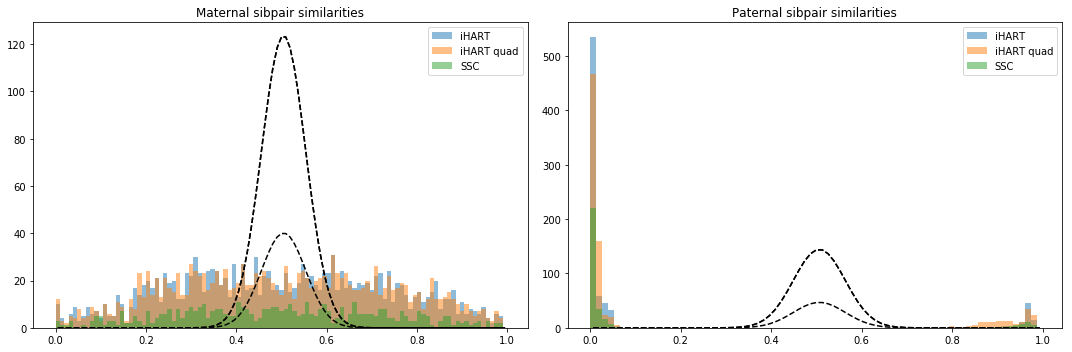

In [214]:
plt.figure(figsize=(15, 5))

plt.subplot(1, 2, 1)
p = 0.5
n = (21+(2*42))
x_axis = np.arange(0, n)
plt.plot((x_axis+0.5)/n, len(ihart_mat)*stats.binom.pmf(x_axis, n, p), color='black', linestyle='--')
plt.plot((x_axis+0.5)/n, len(ihart_quad_mat)*stats.binom.pmf(x_axis, n, p), color='black', linestyle='--')
plt.plot((x_axis+0.5)/n, len(ssc_mat)*stats.binom.pmf(x_axis, n, p), color='black', linestyle='--')
plt.hist(ihart_mat, bins=x_axis/n, alpha=0.5, label='iHART')
plt.hist(ihart_quad_mat, bins=x_axis/n, alpha=0.5, label='iHART quad')
plt.hist(ssc_mat, bins=x_axis/n, alpha=0.5, label='SSC')
plt.legend()
plt.title('Maternal sibpair similarities')

plt.subplot(1, 2, 2)
n = (21+(2*28))
x_axis = np.arange(0, n)
plt.plot((x_axis+0.5)/n, len(ihart_pat)*stats.binom.pmf(x_axis, n, p), color='black', linestyle='--')
plt.plot((x_axis+0.5)/n, len(ihart_quad_pat)*stats.binom.pmf(x_axis, n, p), color='black', linestyle='--')
plt.plot((x_axis+0.5)/n, len(ssc_pat)*stats.binom.pmf(x_axis, n, p), color='black', linestyle='--')
plt.hist(ihart_pat, bins=x_axis/n, alpha=0.5, label='iHART')
plt.hist(ihart_quad_pat, bins=x_axis/n, alpha=0.5, label='iHART quad')
plt.hist(ssc_pat, bins=x_axis/n, alpha=0.5, label='SSC')
plt.legend()
plt.title('Paternal sibpair similarities')

plt.tight_layout()
plt.show()

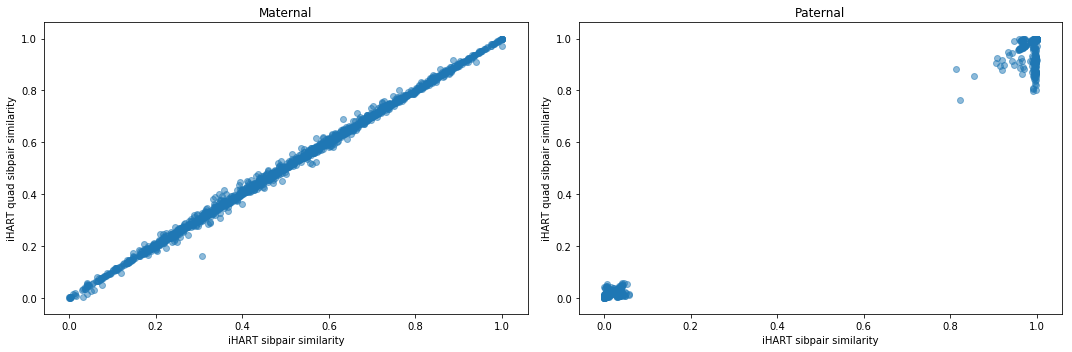

In [215]:
plt.figure(figsize=(15, 5))

plt.subplot(1, 2, 1)
plt.scatter(ihart_mat, ihart_quad_mat, alpha=0.5)
plt.title('Maternal')
plt.xlabel('iHART sibpair similarity')
plt.ylabel('iHART quad sibpair similarity')

plt.subplot(1, 2, 2)
plt.scatter(ihart_pat, ihart_quad_pat, alpha=0.5)
plt.title('Paternal')
plt.xlabel('iHART sibpair similarity')
plt.ylabel('iHART quad sibpair similarity')

plt.tight_layout()
plt.show()

In [216]:
ihart_aut_aut_indices = np.array([child_id_to_affected[x[0]]=='2' and child_id_to_affected[x[1]]=='2' for x in ihart_sibpairs])
ihart_aut_typ_indices = np.array([(child_id_to_affected[x[0]]=='2' and child_id_to_affected[x[1]]=='1') or (child_id_to_affected[x[0]]=='1' and child_id_to_affected[x[1]]=='2') for x in ihart_sibpairs])
ihart_typ_typ_indices = np.array([child_id_to_affected[x[0]]=='1' and child_id_to_affected[x[1]]=='1' for x in ihart_sibpairs])

ssc_aut_aut_indices = np.array([child_id_to_affected[x[0]]=='2' and child_id_to_affected[x[1]]=='2' for x in ssc_sibpairs])
ssc_aut_typ_indices = np.array([(child_id_to_affected[x[0]]=='2' and child_id_to_affected[x[1]]=='1') or (child_id_to_affected[x[0]]=='1' and child_id_to_affected[x[1]]=='2') for x in ssc_sibpairs])
ssc_typ_typ_indices = np.array([child_id_to_affected[x[0]]=='1' and child_id_to_affected[x[1]]=='1' for x in ssc_sibpairs])


print('iHART', 'aut-aut', np.sum(ihart_aut_aut_indices), 'aut-typ', np.sum(ihart_aut_typ_indices), 'typ-typ', np.sum(ihart_typ_typ_indices))
print('SSC', 'aut-aut', np.sum(ssc_aut_aut_indices), 'aut-typ', np.sum(ssc_aut_typ_indices), 'typ-typ', np.sum(ssc_typ_typ_indices))




iHART aut-aut 917 aut-typ 652 typ-typ 23
SSC aut-aut 0 aut-typ 516 typ-typ 0


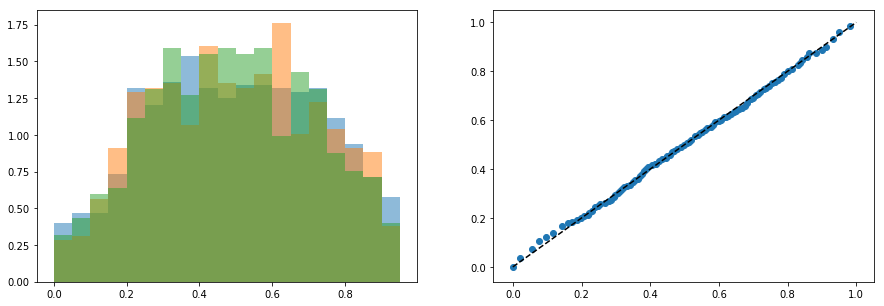

In [217]:
plt.figure(figsize=(15, 5))

plt.subplot(1, 2, 1)
bins = np.arange(0, 1, 0.05)
plt.hist(ihart_quad_mat[ihart_aut_aut_indices], bins=bins, density=True, alpha=0.5)
plt.hist(ihart_quad_mat[ihart_aut_typ_indices], bins=bins, density=True, alpha=0.5)
plt.hist(ssc_mat[ssc_aut_typ_indices], bins=bins, density=True, alpha=0.5)

plt.subplot(1, 2, 2)
plt.scatter(np.quantile(ihart_quad_mat[ihart_aut_aut_indices], np.arange(0, 1, 0.01)), 
            np.quantile(ihart_quad_mat[ihart_aut_typ_indices], np.arange(0, 1, 0.01)))
plt.plot([0, 1], [0, 1], color='black', linestyle='--')

plt.show()

In [219]:
# write to file

with open('sibpair_similarity_scores%s.txt' % ('X' if chroms==['X'] else ''), 'w+') as f:
    f.write('Sibling1\tSibling2\tDataset\tMaternal-Similarity\tPaternal-Similarity\n')
    for i, sibpair in enumerate(ssc_sibpairs):
        f.write('%s\t%s\t%s\t%f\t%f\n' % (sibpair[0], sibpair[1], 'SSC', ssc_mat[i], ssc_pat[i]))
    for i, sibpair in enumerate(ihart_sibpairs):
        f.write('%s\t%s\t%s\t%f\t%f\n' % (sibpair[0], sibpair[1], 'iHART', ihart_mat[i], ihart_pat[i]))
    

In [220]:
# write to file

with open('sibpair_similarity_scores%s_quad.txt' % ('X' if chroms==['X'] else ''), 'w+') as f:
    f.write('Sibling1\tSibling2\tDataset\tMaternal-Similarity\tPaternal-Similarity\n')
    for i, sibpair in enumerate(ssc_sibpairs):
        f.write('%s\t%s\t%s\t%f\t%f\n' % (sibpair[0], sibpair[1], 'SSC', ssc_mat[i], ssc_pat[i]))
    for i, sibpair in enumerate(ihart_sibpairs):
        f.write('%s\t%s\t%s\t%f\t%f\n' % (sibpair[0], sibpair[1], 'iHARTquad', ihart_quad_mat[i], ihart_quad_pat[i]))
    